<a href="https://colab.research.google.com/github/passerim/NLP-per-la-classificazione-di-Fake-News/blob/master/NLP_per_la_classificazione_di_Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP per la classificazione di Fake News

**Progetto per il corso Programmazione di Applicazioni Data Intensive 2019/2020**  

Mattia Passeri  
`mattia.passeri2@studio.unibo.it`

# Descrizione
> L' obiettivo di questo elaborato è esplorare un dataset, famoso per il Natural Language Processing sul sito Kaggle, contenente numerosi articoli in lingua inglese etichettati come Veritieri (True) o Fake News (Fake). Si desidera implementare un sistema, facente uso di tecniche di elaborazione del linguaggio naturale e machine learning, per classificare in modo automatico le notizie nelle due categorie.
* Il dataset è interamente collezionato da fonti reali. Gli articoli autentici sono presi dal sito di informazione Reuters.com. Le fake news sono collezionate dal sito kaggle.com e provengono da un dataset di articoli etichettati da Politifact (un organizzazione di fact‐checking negli USA) in collaborazione con Facebook. Il dataset si concentra particolarmente su notizie di politica, in quanto è l'argomento maggiormente preso di mira dai creatori di fake news. Gli articoli sono stati pubblicati nel 2016 e 2017, durante e dopo il periodo delle elezioni presidenziali degli USA.
1. Ahmed H, Traore I, Saad S. “Detecting opinion spams and fake news using text classification”, Journal of Security and Privacy, Volume 1, Issue 1, Wiley, January/February 2018.
2. Ahmed H, Traore I, Saad S. (2017) “Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques. In: Traore I., Woungang I., Awad A. (eds) Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments. ISDDC 2017. Lecture Notes in Computer Science, vol 10618. Springer, Cham (pp. 127-138).
* Link alla pagina Kaggle del dataset: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

### ***Attenzione***
* Il notebook realizza un'analisi su un corpus piuttosto grande di documenti. Per tanto il tempo di esecuzione di alcune celle è elevato, le celle che richiedono un tempo di esecuzione possibilmente superiore a 5 minuti sono evidenziate con il commento: `# tempo di esecuzione alto`.
* Tempo stimato di esecuzione del notebook in Colab: 25/30 minuti.

## Importazione librerie e caricamento dataset
* Viene utilizzata la libreria Natural Language Toolkit per il NLP e la libreria scikit-learn per il machine learning. I dati vengono gestiti grazie alla libreria Pandas, mentre Scipy e Numpy gestiscono funzioni matematiche e di manipolazione di matrici. Per la visualizzazione di grafici si utilizza Matplotlib e Plotly.

In [1]:
import re, string
import numpy as np
import pandas as pd
from scipy import sparse, stats
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

* Il dataset contenente gli articoli su cui eseguire la classificazione è diviso in due file.
* Si carica il dataset un file per volta con Pandas per procedere all'analisi esplorativa.

* Il dataset è costituito da due file:
** True.csv, contenente articoli veritieri dal sito Reuters.com.
** Fake.csv, contenente articoli etichettati come fake news.




In [2]:
import os 
if not os.path.exists('./True.csv') or not os.path.exists('./Fake.csv'):
    print("E' necessario scaricare il dataset dal sito Kaggle!")
else:
    print('File presenti.')

File presenti.


### Caricamento articoli veritieri
* True.csv viene caricato esplicitando il parsing del campo `date` in formato datetime di Pandas, il formato viene riconosciuto dalla libreria e il parsing viene effettuato correttamente, gli articoli vengono quindi ordinati in ordine decrescente secondo l'attributo `date`.

* Nel file sono presenti 4 attributi:
** `title`: contiene i titoli degli articoli.
** `text`: contine il testo degli articoli.
** `subject`: contiene la categoria.
** date: contiene la data di pubblicazione.

In [3]:
true = pd.read_csv('./True.csv', parse_dates=['date'])

In [4]:
true.sort_values(by=['date'], inplace=True, ignore_index=True, ascending=False)

In [5]:
true.head(10)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31
1,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31
2,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30
3,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29
4,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,2017-12-29
5,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,2017-12-29
6,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,2017-12-29
7,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,2017-12-29
8,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29
9,New York governor questions the constitutional...,NEW YORK/WASHINGTON (Reuters) - The new U.S. t...,politicsNews,2017-12-28


In [6]:
print('Numero articoli caricati:', len(true))
print(true.info())

Numero articoli caricati: 21417
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    21417 non-null  object        
 1   text     21417 non-null  object        
 2   subject  21417 non-null  object        
 3   date     21417 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 669.4+ KB
None


### Intestazione articoli e tweet
* Tutti gli articoli in `true` sono presi dal giornale Retuters.com, il testo degli articoli presenta un'instestazione con indicazione di un luogo e il nome del giornale.
* Alcuni articoli, come i numeri 6 e 7, citano tweet e hanno una struttura del testo differente dagli altri.
> Queste caratteristiche verranno trattate successivamente in quanto possono essere fonti di bias che il modello di learning può sfruttare in maniera indesiderata.

In [7]:
print('Numero articoli non-tweet:', len(true.text[(true.text.str.find('The following statements') < 0)]))

Numero articoli non-tweet: 21322


In [8]:
true.text[(true.text.str.find('The following statements') < 0)]

0        WASHINGTON (Reuters) - The head of a conservat...
1        WASHINGTON (Reuters) - The special counsel inv...
2        WASHINGTON (Reuters) - Trump campaign adviser ...
3        SEATTLE/WASHINGTON (Reuters) - President Donal...
4        WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...
                               ...                        
21412    WASHINGTON (Reuters) - President Barack Obama’...
21413    WASHINGTON (Reuters) - The United States will ...
21414    SEOUL (Reuters) - South Korea warned North Kor...
21415    OMAHA, Neb. (Reuters) - President Barack Obama...
21416    AMES, Iowa (Reuters) - U.S. Democratic preside...
Name: text, Length: 21322, dtype: object

In [9]:
print('Numero tweet:', len(true[(true.text.str.find('The following statements') == 0)]))

Numero tweet: 95


In [10]:
(true[(true.text.str.find('The following statements') == 0)]).head(5)

,title,text,subject,date
6,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,2017-12-29
7,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,2017-12-29
10,"Trump on Twitter (Dec 27) - Trump, Iraq, Syria",The following statements were posted to the ve...,politicsNews,2017-12-28
11,Factbox: Trump on Twitter (Dec 28) - Vanity Fa...,The following statements were posted to the ve...,politicsNews,2017-12-28
100,"Trump on Twitter (Dec 26) - Hillary Clinton, T...",The following statements were posted to the ve...,worldnews,2017-12-26


* Stampa di esempio per osservare la struttura dei tweet.

In [11]:
true.text[(true.text.str.find('The following s') == 0)].values[:1]

array(['The following statements\xa0were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS.  The opinions expressed are his own.\xa0Reuters has not edited the statements or confirmed their accuracy.  @realDonaldTrump : - While the Fake News loves to talk about my so-called low approval rating, @foxandfriends just showed that my rating on Dec. 28, 2017, was approximately the same as President Obama on Dec. 28, 2009, which was 47%...and this despite massive negative Trump coverage & Russia hoax! [0746 EST] - Why is the United States Post Office, which is losing many billions of dollars a year, while charging Amazon and others so little to deliver their packages, making Amazon richer and the Post Office dumber and poorer? Should be charging MUCH MORE! [0804 EST] -- Source link: (bit.ly/2jBh4LU) (bit.ly/2jpEXYR) '],
      dtype=object)

### Pulizia dei dati
* Si procede sucessivamente all'analisi esplorativa parziale del primo file caricato, per trovare caratteristiche dei dati che possano dar luogo a problemi.
* In particolare si vuole verificare che non esistano record con attributi mancanti e con testo vuoto o troppo breve.



In [12]:
true.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

* Aggiunta di una colonna al DataFrame con il numero di parole dell'attributo `text` per ogni articolo.
* Viene graficato l'andamento del numero di articoli con un numero di parole maggiore o uguale a una certa quantità, per un numero di parole che va da 0 al primo quartile.

In [13]:
true['num_words'] = true.text.apply(lambda x: len(x.split()))

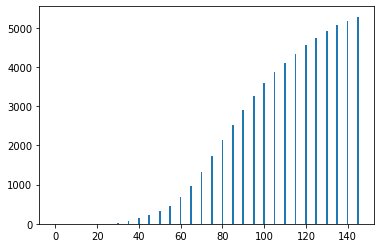

In [14]:
small_text = []
for i in range(0,int(true.num_words.quantile(.25)),5):
    small_text.append((true['num_words'] < i).sum())
plt.bar(list(range(0,int(true.num_words.quantile(.25)),5)), small_text)
plt.show()

* Dal grafico emerge che la quantità di articoli con meno di 20/30 parole è trascurabile e possono reputarsi outliers o cattivi esempi che è preferibile escludere dal dataset.
* Di conseguenza vengono mostrati tutti gli articoli con meno di 20 parole per verifica e poi vengono eliminati dal DataFrame.

In [15]:
true[true.text.apply(lambda x: len(x.split()) < 20)]

,title,text,subject,date,num_words
19236,Graphic: Supreme Court roundup,,politicsNews,2016-06-16,0


In [16]:
true.drop(true[true.text.apply(lambda x: len(x.split()) < 20)].index, inplace=True)
true.reset_index(drop=True, inplace=True)

### Caricamento dataset Fake News
* Si carica il dataset Fake.csv contenente articoli etichettati come "falsi".
* La prima criticità presente in questo caso è che Pandas non riesce ad effettuare il parsing delle date degli articoli. Si rende quindi necessario controllare il motivo del malfunzionamento e procedere al parsing manuale.

In [17]:
fake = pd.read_csv('./Fake.csv', parse_dates=['date'])

* L' attributo `date` ha Dtype=object, Pandas ha fallito il parsing!
* Il campo `date` di alcuni articoli contiene valori che non rappresentano una data.
* Viene effettuato il parsing forzato e poi eliminati gli articoli con data non corretta. Infatti molto probabilmente saranno articoli mal formattati che non rappresentano un'aggiunta significativa al campione.

In [18]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [19]:
fake.date.value_counts()

May 10, 2017         46
May 26, 2016         44
May 6, 2016          44
May 5, 2016          44
May 11, 2016         43
                     ..
14-Feb-18             1
November 19, 2017     1
December 9, 2017      1
Apr 2, 2015           1
December 4, 2017      1
Name: date, Length: 1681, dtype: int64

In [20]:
fake.date = fake.date.apply(lambda x: pd.to_datetime(x, errors='coerce'))

In [21]:
fake.isna().sum()

title       0
text        0
subject     0
date       10
dtype: int64

In [22]:
fake.dropna(inplace=True)
fake.reset_index(inplace=True, drop=True)

In [23]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23471 entries, 0 to 23470
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    23471 non-null  object        
 1   text     23471 non-null  object        
 2   subject  23471 non-null  object        
 3   date     23471 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 733.6+ KB


### Pulizia articoli
* Viene ripetuto un procedimento analogo al precedente per filtrare gli articoli con testo non presente, troppo breve o composto esclusivamente da link.
* La soglia di parole sotto al quale un articolo viene scartato è sempre 20.

In [24]:
fake['num_words'] = fake.text.apply(lambda x: len(x.split()))

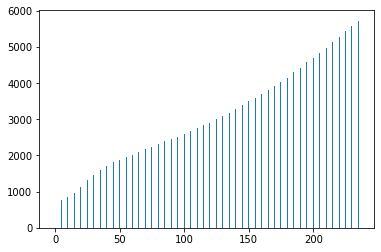

In [25]:
small_text = []
for i in range(0,int(fake.num_words.quantile(.25)),5):
    small_text.append((fake['num_words'] < i).sum())
plt.bar(list(range(0,int(fake.num_words.quantile(.25)),5)), small_text)
plt.show()

In [26]:
fake[fake.text.apply(lambda x: len(x.split()) < 20)]

,title,text,subject,date,num_words
10922,TAKE OUR POLL: Who Do You Think President Trum...,,politics,2017-05-10,0
11040,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,2017-04-26,0
11116,MY FAVORITE EXCUSES…Featuring Hillary Rotten C...,Enjoy:,politics,2017-04-17,1
11189,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,2017-04-06,0
11224,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,2017-04-02,0
...,...,...,...,...,...
21819,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,2015-04-25,0
21849,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,2015-04-14,0
21863,(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...,,left-news,2015-04-12,0
21872,ONLY IN DETROIT: SQUATTING ON THE SQUATTER TAK...,You won t want to miss this,left-news,2015-04-09,7


In [27]:
fake.drop(fake[fake.text.apply(lambda x: len(x.split()) < 20)].index, inplace=True)
fake.reset_index(drop=True, inplace=True)

* Si visualizzano alcune info sul dataset e poi si ordinano le gli articoli per data di pubblicazione in ordine decrescente.

In [28]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22350 entries, 0 to 22349
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   title      22350 non-null  object        
 1   text       22350 non-null  object        
 2   subject    22350 non-null  object        
 3   date       22350 non-null  datetime64[ns]
 4   num_words  22350 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 873.2+ KB


In [29]:
fake.sort_values(by=['date'], inplace=True, ignore_index=True, ascending=False)

In [30]:
fake.head(5)

,title,text,subject,date,num_words
0,MSNBC ANCHOR Flabbergasted at What Texas Teach...,If we protect every other government building ...,politics,2018-02-19,220
1,WATCH: SNOWFLAKES ASKED Communist Party Platfo...,Ami Horowitz is fantastic! Check out this man ...,politics,2018-02-19,137
2,Democrat Senator Warns Mueller Not To Release ...,"According to The Hill, Democrat Senator Bob Ca...",politics,2018-02-19,181
3,JUST IN: BADASS GENERAL JOHN KELLY Shoved Chin...,Just one more reminder of why President Trump ...,politics,2018-02-18,183
4,DOJ’s JEFF SESSIONS Opens Investigation Into W...,Thank goodnesss Jeff Sessions is moving on fin...,politics,2018-02-18,201


## Analisi esplorativa
* Viene effettuata l'analisi esplorativa del dataset per comprenderne le caratteristiche ed eventuali problematiche.
* Per prima cosa si osserva la distribuzione del numero di articoli in `fake` e in `true` in relazione alla data di pubblicazione, le due distribuzioni vengono messe a confronto in uno stesso grafico.
* Buona parte degli articoli di entrambe le categorie sono stati pubblicati nel medesimo periodo. Per i valori estremi della linea temporale ci sono tuttavia delle disparità nelle due distribuzioni.

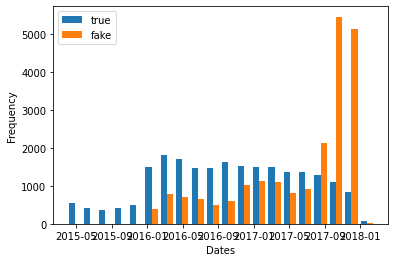

In [31]:
plt.hist([fake.date, true.date], bins=20,  label=['true', 'fake'])
plt.xlabel('Dates')
plt.ylabel('Frequency')
plt.legend()
plt.show()

* Si studia la differenza tra le categorie di notizie vere e false nel numero di caratteri in maiuscolo presenti nel titolo.
* E' sostanziale la differenza tra le due categorie nella percentuale di caratteri in maiuscolo presenti nel titolo di ciascun articolo.
* Sebbene questo sia un dato su cui potersi basare per migliorare l'efficacia della predizione, non sarà una feature utilizzata in seguito nei modelli di classificazione, in quanto si desidera incentrare la classificazione sulle parole.
* Il titolo degli articoli in `fake` ha mediamente più del 25% dei caratteri in maiuscolo, contro il solo 3/4% per il titolo degli articoli in `true`.

In [32]:
fake['uppercase'] = fake.title.apply(lambda title: sum(1 for c in title if c.isupper()))

In [33]:
fake['uppercase'].mean() / 100

0.2756496644295302

In [34]:
true['uppercase'] = true.title.apply(lambda title: sum(1 for c in title if c.isupper()))

In [35]:
true['uppercase'].mean() / 100

0.035520171834142696

* Vengono mostrati i grafici relativi alla distribuzione dei valori nel campo `subject` dei due dataset.
* Il campo in questione non ha molta rilevanza in quanto non c'è coerenza tra i valori presenti nei due DataFrame. Questo attributo sarà conseguentemente ignorato in seguito.

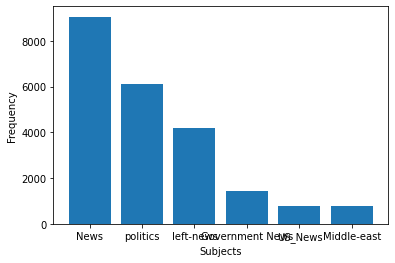

News               9050
politics           6111
left-news          4187
Government News    1441
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [36]:
plt.bar(fake.subject.value_counts().index, fake.subject.value_counts())
plt.xlabel('Subjects')
plt.ylabel('Frequency')
plt.show()
fake.subject.value_counts()

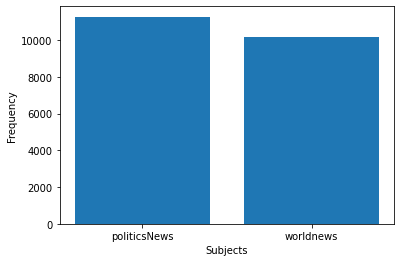

politicsNews    11271
worldnews       10145
Name: subject, dtype: int64

In [37]:
plt.bar(true.subject.value_counts().index, true.subject.value_counts())
plt.xlabel('Subjects')
plt.ylabel('Frequency')
plt.show()
true.subject.value_counts()

### Lunghezza articoli e frequenza parole
* Vengono di seguito analizzate le distribuzioni del numero di parole nel testo degli articoli e degli (1-2-3)-ngrammi più frequenti, per entrambe le classi.

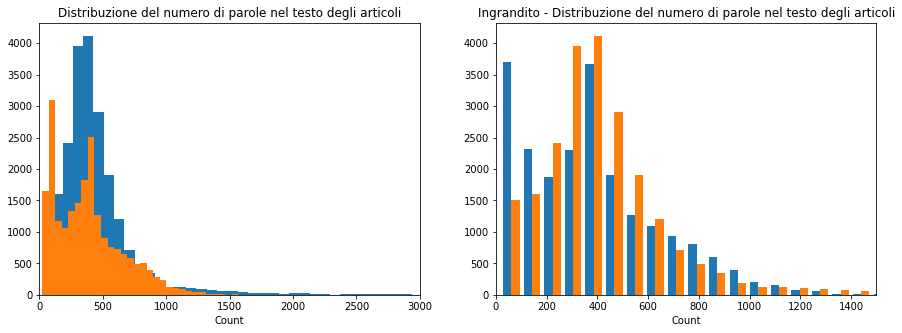

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(fake["num_words"], bins=100, label='fake')
ax[0].hist(true["num_words"], bins=100, label='true')
ax[0].set(xlim = (0, 3000), xlabel='Count')
ax[0].set_title('Distribuzione del numero di parole nel testo degli articoli')
ax[1].hist([true["num_words"], fake["num_words"]], bins=100,label=['fake', 'true'])
ax[1].set(xlim = (0, 1500), xlabel='Count')
ax[1].set_title('Ingrandito - Distribuzione del numero di parole nel testo degli articoli')
fig.show()

* La distribuzione degli (1-2-3)-ngrammi più frequenti per ciascuna classe permette di capire quali sono i concetti più ricorrenti nel corpus.

In [39]:
# tempo di esecuzione alto
n = 20
fig = make_subplots(rows=3, cols=1, vertical_spacing=0.1, subplot_titles=
                    ('Top {} unigrams'.format(n),
                     'Top {} bigrams'.format(n),
                     'Top {} trigrams'.format(n)
))
for i in range(1,4):
    vec = CountVectorizer(stop_words='english', ngram_range=(i,i), lowercase=True).fit(true['text'])
    bag_of_words = vec.transform(true['text'])
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:n]
    df_plot = pd.DataFrame(words_freq, columns = ['ngram' , 'count'])
    fig.add_trace( go.Bar( x=df_plot['ngram'], y=df_plot['count'] ), row=i, col=1 )
    fig.update_xaxes(title_text="Words", row=i, col=1)
    fig.update_yaxes(title_text="Frequency", row=i, col=1)
fig.update_layout(height=1536, title_text='Distribuzione ngrammi più comuni per la classe True')
fig.show()

In [40]:
# tempo di esecuzione alto
n = 20
fig = make_subplots(rows=3, cols=1, vertical_spacing=0.1, subplot_titles=
                    ('Top {} unigrams'.format(n),
                     'Top {} bigrams'.format(n),
                     'Top {} trigrams'.format(n)
))
for i in range(1,4):
    vec = CountVectorizer(stop_words='english', ngram_range=(i,i), lowercase=True).fit(fake['text'])
    bag_of_words = vec.transform(fake['text'])
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:n]
    df_plot = pd.DataFrame(words_freq, columns = ['ngram' , 'count'])
    fig.add_trace( go.Bar( x=df_plot['ngram'], y=df_plot['count'] ), row=i, col=1 )
    fig.update_xaxes(title_text="Words", row=i, col=1)
    fig.update_yaxes(title_text="Frequency", row=i, col=1)
fig.update_layout(height=1536, title_text='Distribuzione ngrammi più comuni per la classe Fake')
fig.show()

## Preprocessing: text cleaning, tokenization e lemmatization
* Prima di procedere alla classificazione, il testo deve essere preprocessato per: eliminare parole non rilevanti e stopwords, suddividere il testo in tokens ed estrarre il lemma di ciascun token. Tutte queste operazioni possono anche essere viste come una preliminare forma di riduzione della dimensionalità.
* Per effettuare queste operazioni si utilizza, quando è possibile, la libreria nltk.
* Per quanto riguarda la lemmatizzazione, nonostante sia un procedimento piuttosto oneroso per i costi di calcolo, è cruciale per ridurre il vocabolario di un corpus di documenti cosi vasto.
La lemmatization è stata preferita allo stemming in quanto, a fronte di un numero simile di feature generate, produce parole che mantengono senso compiuto favorendo l'interpretazione.

In [41]:
nltk.download('punkt')
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
wnl = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Reuters e tweets
*    Tornando per un momento alla cella in cui si sono mostrati, a scopo esemplificativo, i primi 10 articoli della categoria "True", si osservano due particolarità.
1.   Gli articoli della categoria "True" sono presi dal giornale Reuters, per tanto nel testo degli articoli è presente sempre un riferimento al giornale e al luogo o area geografica di cui tratta la notizia (es. "WASHINGTON (Reuters) - ..."). Questa presenza di parole uguali in tutti gli articoli di una stessa categoria è un pattern che probabilmente l'algoritmo di learning andrebbe a sfruttare per effettuare la classificazione, si tratta perciò di un bias che è consigliabile rimuovere.
2.   Alcuni articoli fanno riferimento a tweet della pagina Twitter di Donald Trump. Questi articoli hanno tutti una struttura simile e presentano uno stesso avviso che cita la pagina Twitter da cui è stato preso il tweet. Si è scelto di filtrare l'avviso per rimovere una porzione di testo che non possiede contenuto informativo.

* Questa funzione permette di elimare la testata di ciascun articolo, dove sono riportati il luogo e il giornale. Inoltre rimuove le intestazioni dei tweet citati da alcuni articoli.

In [42]:
def clean_reuters(text):
    if "@realDonaldTrump : - " in text:
        return text.split("@realDonaldTrump : - ")[1]
    elif "(Reuters) -" in text:
        return text.split("(Reuters) - ")[1]
    else:
        return text

* Questa funzione realizza, per mezzo di espressioni regolari, un filtro su: link, parole tra parentesi, punteggiatura, numeri e parole più corte di 2 caratteri.

In [43]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http:\S+', '', text)
    text = text.replace('–', '')
    text = text.replace('-', '')
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation + '«»‘’“”’'), ' ', text)
    text = re.sub(r' \b\d{,}\b ', ' ', text)
    text = re.sub(r' \b\d{,}\b ', ' ', text)
    text = re.sub(r' \b\w{1,2}\b ', ' ', text)
    text = re.sub(r' \b\w{1,2}\b ', ' ', text)
    return text

* Funzione che realizza la lemmatizzazione utilizzando la libreria nltk.

In [44]:
penn_to_wn = {"N": "n", "V": "v", "J": "a", "R": "r"}
def tokenize_with_lemmatization(text, stoplist):
    sent = []
    for token, tag in nltk.pos_tag(nltk.tokenize.word_tokenize(text)):
        if tag[0] in penn_to_wn:
            tok = wnl.lemmatize(token, penn_to_wn[tag[0]])
            if tok not in stoplist:
                sent.append(wnl.lemmatize(token, penn_to_wn[tag[0]]))
        elif token not in stoplist:
            sent.append(token)    
    return " ".join(sent)

* Funzione per eliminare stopwords, la lista delle stopwords è passata come parametro alla funzione e in questo caso è presa da `nltk`.

In [45]:
def remove_stop(text, stoplist):
    sent = []
    for token in nltk.tokenize.word_tokenize(text):
        if token not in stoplist:
            sent.append(token)
    return " ".join(sent)

* Funzione che realizza lo stemming di una stringa alla volta utilizzando `nltk`.

In [46]:
ps = nltk.stem.PorterStemmer()
def tokenize_with_stemming(text, stoplist):
    return " ".join([ps.stem(token) for token
            in nltk.word_tokenize(text) if token not in stoplist])

In [47]:
stop_list = nltk.corpus.stopwords.words('english')
stopwords_set = set(stop_list)

In [48]:
# tempo di esecuzione alto
true['text_clean'] = true.text.apply(lambda x: clean_reuters(x))
true['text_clean'] = true['text_clean'].apply(lambda x: clean_text(x))
true["text_lemmatize"] =  true['text_clean'].apply(lambda x: tokenize_with_lemmatization(x, stopwords_set))

In [49]:
# tempo di esecuzione alto
fake['text_clean'] = fake.text.apply(lambda x: clean_text(x))
fake["text_lemmatize"] =  fake['text_clean'].apply(lambda x: tokenize_with_lemmatization(x, stopwords_set))

## Sentiment Analysis sui titoli con Vader
* Si utilizza il modello Vader di `nltk` per compiere la sentiment analysis sui titoli degli articoli con l'intento di rilevare correlazioni tra la classe e il punteggio `'compound'` calcolato dal modello.
* E' un'analisi interessante in quanto solitamente gli articoli di giornale hanno titoli sensazionalistici che mirano a catturare l'attenzione dei lettori.
* In questo caso, sebbene numerosi articoli presentino un sentimento marcato, in negativo o in positivo, in media non predomina un sentimento pittosto che un altro e anche la media dei punteggi delle due classi è simile.

In [50]:
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



In [51]:
fake['title_sentiment'] = fake.title.str.lower().apply(lambda x: vader.polarity_scores(x)['compound'])

In [52]:
true['title_sentiment'] = true.title.str.lower().apply(lambda x: vader.polarity_scores(x)['compound'])

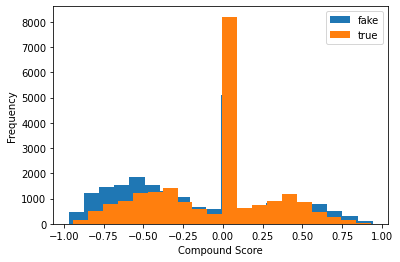

In [53]:
fake['title_sentiment'].plot.hist(bins=20, label='fake');
true['title_sentiment'].plot.hist(bins=20, label='true');
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [54]:
true['title_sentiment'].mean()

-0.06747566772506773

In [55]:
fake['title_sentiment'].mean()

-0.16024197762863548

* La differenza nel punteggio `'compound'` tra le due classi, come si nota dal grafico e dalle medie calcolate, non è  molto significativa al fine di discriminare le classi stesse.
* La maggioranza degli articoli presenta un titolo con sentimento "neutro".

## Preparazione train e test set per la classificazione

* Si aggiunge una colonna ad entrambi i DataFrame con il valore target della classe corrispondente. Si è scelto di indicare con -1 gli articoli appartenenti a `true` e con +1 gli articoli appartenenti a `false`.
* Successivamente i due DataFrame vengono combinati in un nuovo DataFrame `articles`, vengono scartate le colonne non utilizzate per la classificazione e si procede alla preparazione di train e validation set.

In [56]:
true['label'] = -1

In [57]:
fake['label'] = 1

In [58]:
articles = pd.concat([true, fake], ignore_index=True)

* Panoramica della distribuzione delle classi all'interno del dataset unificato. Le due classi sono bilanciate a meno di una piccola percentuale.

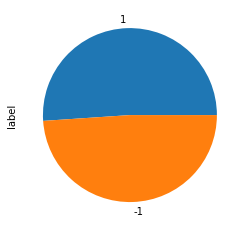

In [59]:
articles['label'].value_counts().plot.pie()
plt.show()

In [60]:
articles.drop(columns=['title', 'subject', 'date', 'num_words', 'text', 'text_clean'], inplace=True)

In [61]:
articles.head(5)

,uppercase,text_lemmatize,title_sentiment,label
0,4,head conservative republican faction congress ...,-0.4939,-1
1,7,special counsel investigation link russia pres...,0.0000,-1
2,8,trump campaign adviser george papadopoulos tel...,0.0000,-1
3,4,president donald trump call postal service fri...,0.2449,-1
4,3,white house say friday set kick talk next week...,0.0000,-1


### Train set, validation set e test set
* Si utilizza una funzione di sklearn per suddividere il DataFrame in tre insiemi: training set (35% delle istanze), validation set (35% delle istanze) e test set(30% delle istanze) rispettando la proporzione tra le classi.
* I tre insiemi vengono usati nel seguente modo:
*1. I modelli verranno addestrati con k cross fold validation stratificata e grid search sul training set, per trovare i migliori iperparametri.
*2. Ciascun modello viene testato sul validation set con la migliore combinazione di iperparametri trovata al passo precedente.
*3. I punteggi ottenuti sul validation set vengono confrontati per trovare il modello con la migliore accuratezza.
*4. Si testa il modello migliore sul test set.


In [62]:
from sklearn.model_selection import train_test_split
articles_train, articles_test = train_test_split(articles, test_size=0.3, random_state=42)

In [63]:
articles_train, articles_val = train_test_split(articles_train, test_size=0.5, random_state=42)

In [64]:
articles_train.head(10)

,uppercase,text_lemmatize,title_sentiment,label
22023,12,gene simmons 68yearold kiss bassist colead sin...,-0.5423,1
32632,19,know trump tell access hollywood host billy bu...,0.0000,1
19481,5,united state tuesday condemn attempted missile...,-0.4019,-1
20765,3,democratic presidential candidate hillary clin...,0.0000,-1
11521,1,trump administration major state appear head s...,0.0000,-1
12129,2,two month dominant military force eastern liby...,0.0000,-1
42845,54,cleanse history continue heck wrong city memph...,-0.5093,1
23486,19,official allegedly affiliate united state park...,0.0000,1
11805,3,union pacific corp say saturday repair rail li...,-0.3400,-1
27084,23,providence city council vote thursday give fir...,-0.9313,1


## Modello di classificazione con Regressione Logistica
* Viene costruita una Pipeline di sklearn che racchiude una classe per l'estrazione di feature, una classe per la trasformazione di feature e un modello di classificazione.
** CountVectorizer: permette di costruire la matrice termini-documenti che costituisce la rappresentazione di un corpus di documenti secondo il modello Bag-Of-Words.
** TfidfTransformer: trasforma una matrice termini-documenti in una sua versione pesata con schema tf-idf e normalizzata con norma L2.
** Logistic regression: modello di classificazione lineare scelto per discriminare le classi.



In [65]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer

In [66]:
# tempo di esecuzione alto
logi_model = Pipeline([
    ("vectorizer", CountVectorizer(max_df=0.9, ngram_range=(1,1))),
    ("transformer", TfidfTransformer()),
    ("classifier", LogisticRegression(solver='saga', random_state=42))
])
logi_grid = {
    "vectorizer__min_df": [10, 100],
    "classifier__penalty": ['l1', 'l2'],
    "classifier__C": [10, 100]
}
skf = StratifiedKFold(3, shuffle=True, random_state=42)
logi_gs = GridSearchCV(logi_model, logi_grid, cv=skf)
logi_gs.fit(articles_train["text_lemmatize"], articles_train["label"]);

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.6/dist-packages/sklearn

In [67]:
logi_gs.best_params_

{'classifier__C': 10, 'classifier__penalty': 'l1', 'vectorizer__min_df': 10}

In [68]:
pd.DataFrame(logi_gs.cv_results_, columns=['mean_fit_time', 'param_classifier__C', 'param_classifier__penalty', 'param_vectorizer__min_df', 'params', 'mean_test_score', 'rank_test_score']).sort_values(by='rank_test_score').head(3)

,mean_fit_time,param_classifier__C,param_classifier__penalty,param_vectorizer__min_df,params,mean_test_score,rank_test_score
0,12.924357,10,l1,10,"{'classifier__C': 10, 'classifier__penalty': '...",0.975584,1
4,40.966314,100,l1,10,"{'classifier__C': 100, 'classifier__penalty': ...",0.975519,2
6,4.125905,100,l2,10,"{'classifier__C': 100, 'classifier__penalty': ...",0.974605,3


In [69]:
logi_gs.score(articles_val["text_lemmatize"], articles_val["label"])

0.9798276537406972

## Modello di classificazione con Perceptron
* Viene costruita una seconda Pipeline di sklearn che differisce dalla precedente per l'uso del modello lineare di classificazione Perceptron.
** CountVectorizer: permette di costruire la matrice termini-documenti che costituisce la rappresentazione di un corpus di documenti secondo il modello Bag-Of-Words.
** TfidfTransformer: trasforma una matrice termini-documenti in una sua versione pesata e normalizzata con norma L2.
** Perceptron: modello di classificazione lineare scelto per discriminare le classi.

In [70]:
# tempo di esecuzione alto
from sklearn.linear_model import Perceptron
perc_model = Pipeline([
    ("vectorizer", CountVectorizer(max_df=0.9, ngram_range=(1,1))),
    ("transformer", TfidfTransformer()),
    ("classifier", Perceptron(random_state=42))
])
perc_grid = {
    "vectorizer__min_df": [10, 100],
    "classifier__penalty": ['l1', 'l2'],
    "classifier__alpha": [0.001, 0.0001]
}
skf = StratifiedKFold(3, shuffle=True, random_state=42)
perc_gs = GridSearchCV(perc_model, perc_grid, cv=skf)
perc_gs.fit(articles_train["text_lemmatize"], articles_train["label"]);

In [71]:
perc_gs.best_params_

{'classifier__alpha': 0.0001,
 'classifier__penalty': 'l2',
 'vectorizer__min_df': 10}

In [72]:
pd.DataFrame(perc_gs.cv_results_, columns=['mean_fit_time', 'param_classifier__alpha', 'param_classifier__penalty', 'param_vectorizer__min_df', 'params', 'mean_test_score', 'rank_test_score']).sort_values(by='rank_test_score').head(3)

,mean_fit_time,param_classifier__alpha,param_classifier__penalty,param_vectorizer__min_df,params,mean_test_score,rank_test_score
6,1.946664,0.0001,l2,10,"{'classifier__alpha': 0.0001, 'classifier__pen...",0.934717,1
7,1.897542,0.0001,l2,100,"{'classifier__alpha': 0.0001, 'classifier__pen...",0.932889,2
5,1.946532,0.0001,l1,100,"{'classifier__alpha': 0.0001, 'classifier__pen...",0.905275,3


In [73]:
perc_gs.score(articles_val["text_lemmatize"], articles_val["label"])

0.9518213866039953

## Confronto fra modelli
* Viene creato un classificatore "dummy" che predice sempre la classe più comune ed è leggermente più performante di un classificatore completamente casuale. Inoltre funge da baseline e permette di evidenziare problemi di sbilanciamento tra le classi nel caso si ottenga un'accuratezza molto più alta di 1/2.
* Poi vengono confrontati i modelli addestrati per valutare quale modello abbia accuratezza migliore con una confidenza del 95%.

### Modello dummy
* Il modello dummy, che funge da baseline, è un modello che predice sempre la classe più frequente.

In [74]:
from sklearn.dummy import DummyClassifier

In [75]:
dummy_model = Pipeline([
    ("vectorizer", CountVectorizer(ngram_range=(1,1))),
    ("transformer", TfidfTransformer()),
    ("classifier", DummyClassifier(strategy="most_frequent", random_state=42))
])
dummy_model.fit(articles_train["text_lemmatize"], articles_train["label"]);

In [76]:
dummy_model.score(articles_val["text_lemmatize"], articles_val["label"])

0.5121425773599687

### Confronto
* Sia il modello che utilizza il Perceptron come classificatore che il modello che fa uso di Regressione Logistica hanno punteggi chiaramente migliori del modello dummy.
* Il confronto viene perciò effettuato tra il modello `logi_model` (Regressione Logistica) e il modello `perc_model` (Perceptron).

In [77]:
def conf_interval(a, N, Z=1.96):
    c = (2 * N * a + Z**2) / (2 * (N + Z**2))
    d = Z * np.sqrt(Z**2 + 4*N*a - 4*N*a**2) / (2 * (N + Z**2))
    return c - d, c + d

In [78]:
def model_conf_interval(model, X, y, level=0.95):
    a = model.score(X, y)
    N = len(X)
    Z = stats.norm.ppf((1 + level) / 2)
    return conf_interval(a, N, Z)

In [79]:
def diff_interval(a1, a2, N1, N2, Z):
    d = abs(a1 - a2)
    sd = np.sqrt(a1 * (1-a1) / N1 + a2 * (1-a2) / N2)
    return d - Z * sd, d + Z * sd

In [80]:
def model_diff_interval(m1, m2, X, y, level=0.95):
    a1 = m1.score(X, y)
    a2 = m2.score(X, y)
    N = len(X)
    Z = stats.norm.ppf((1 + level) / 2)
    return diff_interval(a1, a2, N, N, Z)

* Viene calcolata l'accuratezza dei due modelli con il 95% di confidenza.

In [81]:
print('Accuratezza del modello con Regressione Logistica al 95% di confidenza:')
model_conf_interval(logi_gs, articles_val["text_lemmatize"], articles_val["label"])

Accuratezza del modello con Regressione Logistica al 95% di confidenza:


(0.9774779990618299, 0.9819367057246693)

In [82]:
print('Accuratezza del modello con Percettrone al 95% di confidenza:')
model_conf_interval(perc_gs, articles_val["text_lemmatize"], articles_val["label"])

Accuratezza del modello con Percettrone al 95% di confidenza:


(0.9483154518141348, 0.9551007620399279)

* La differenza nell'accuratezza dei due modelli sarà modellabile con una distribuzione normale, di media pari alla differenza reale tra le due accuratezze e di varianza pari alla somma delle varianze dei due modelli. Se l'intervallo di confidenza al 95% della distribuzione della differenza non comprende lo zero, allora si può dire che statisticamente un modello è migliore dell'altro.

In [83]:
print('Differenza degli intervalli di confidenza:')
model_diff_interval(logi_gs, perc_gs, articles_val["text_lemmatize"], articles_val["label"])

Differenza degli intervalli di confidenza:


(0.023949550934917976, 0.03206298333848594)

* La differenza tra l'accuratezza del modello con Regressione Logistica e il modello con Percettrone è statisticamente significativa.
* Il modello con Regressione Logistica è migliore.

## Interpretazione della conoscenza appresa
* I pesi che l'algoritmo di learning ha assegnato a ciascuna variabile(==parola) permettono di capire quanto ciascuna parola influisca nel determinare la classe di un documento.
* A pesi negativi corrispondono parole che orientano il modello verso la predizione di un articolo di classe -1 : True.
* A persi postivi corrispondo parole che orientano il modello verso la predizione di un articolo di classe +1 : Fake.

In [84]:
coefs = pd.Series(logi_gs.best_estimator_.named_steps['classifier'].coef_[0], index=logi_gs.best_estimator_.named_steps['vectorizer'].get_feature_names())
coefs.sort_values(inplace=True, ascending=True)

* Osservando le parole che determinano maggiormente la classe True, si nota che il modello ha correttamente individuato parole che nel contesto di un articolo di giornale ne evidenziano l'autenticità. 
* Parole come: say e spokeswoman sono collegate al riportare le fonti di ciò che viene scritto.
* I giorni della settimana sono indicazioni di momenti e date, molto frequenti nella cronaca.
* Reuters e newspaper dimostrano che il modello ha, per cosi dire, indovinato la natura dei documenti che ha elaborato.
* Altre parole fanno riferimento al mondo della politica, principale argomento degli articoli.

In [85]:
coefs.head(15)

say            -32.476099
reuters        -28.746632
wednesday      -24.854795
thursday       -24.218771
nov            -22.319420
link           -21.590736
tuesday        -18.307143
newspaper      -17.037637
rival          -16.652357
friday         -16.294771
monday         -15.308128
presidential   -14.603772
spokeswoman    -14.564094
capital        -11.879732
nightclub      -11.281737
dtype: float64

* Tra le parole che determinano maggiormente la classe Fake:
* getty, pic, image sono riferimenti a immagini e foto, sono comuni in articoli dove si punta al coinvolgimento emotivo del lettore senza veri e propri contenuti.
* via, read, watch sono parole che rimandano all'usanza, tipica di articoli non veritieri, di rimandare a fonti non autorevoli come video o altre pagine web.

In [86]:
coefs.tail(15)

feature    17.680557
wire       17.725167
nyt        18.293875
entire     19.630786
getty      20.801982
nyp        20.893167
watch      21.713700
rep        22.242100
com        22.745920
pic        22.897167
sen        24.712071
gop        30.913776
image      32.537633
read       37.532482
via        82.854578
dtype: float64

## Accuratezza sul test set
* Si osserva la capacità del modello di generalizzare su dati nuovi.
* Si calcolano sul test set la matrice di confusione e tutte le metriche di interesse per la classificazione.

Classification report for classifier GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.9,
                                                        max_features=None,
                                                        min_df=1,
                       

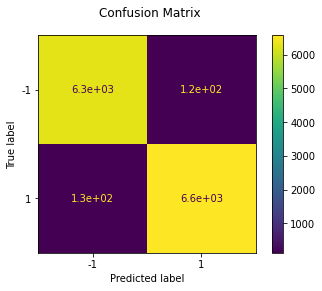

In [87]:
from sklearn import metrics
print("Classification report for classifier %s:\n%s\n" % (logi_gs, metrics.classification_report(articles_test["label"], logi_gs.predict(articles_test["text_lemmatize"]))))
disp = metrics.plot_confusion_matrix(logi_gs, articles_test["text_lemmatize"], articles_test["label"])
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

## Predizione su nuovi articoli recenti
* Il modello viene testato su due articoli recenti: 
** l'articolo nella variabile `reuters` è preso dalla famosa testata giornalistica ed è attendibile, per cui ci si aspetta che sia classificato come -1
** l'articolo nella variabile `onion` è preso da una famosa testata umoristica americana, l'articolo contiene notizie false e perciò ci si aspetta sia classificato +1.



In [88]:
def predict(text, model):
    text = clean_reuters(text)
    text = clean_text(text)
    text = tokenize_with_lemmatization(text, stopwords_set)
    pred = model.predict([text])
    print("=> ", pred, np.where(pred > 0, 'fake', 'true')[0])

In [89]:
reuters = 'WASHINGTON (Reuters) - U.S. President Donald Trump on Wednesday threatened to cut off funding to schools that do not open in the fall and criticized a federal health agency’s guidelines for reopening schools as “very tough & expensive.” The Republican president, who is seeking re-election in November, accused Democrats of wanting to keep schools shut for political reasons, despite a surge in coronavirus cases across the country. “The Dems think it would be bad for them politically if U.S. schools open before the November Election, but is important for the children & families. May cut off funding if not open!” Trump said on Twitter, pointing to schools reopening in some European countries with no problems. It was not clear what specific federal aid the Republican president had in mind. States are responsible for primary and secondary education under the U.S. Constitution, but the federal government provides some supplementary funding. Trump also took aim at the U.S. Centers for Disease Control and Prevention, the nation’s health protection agency whose director sits on the White House coronavirus task force. “I disagree with @CDCgov on their very tough & expensive guidelines for opening schools. While they want them open, they are asking schools to do very impractical things. I will be meeting with them!!!” Trump said in a separate Twitter post. On Tuesday, Trump held meetings about school reopenings at the White House and said he would pressure state governors to open schools in the fall.'
predict(reuters, logi_gs)

=>  [-1] true


In [90]:
onion = 'WASHINGTON - In a letter to top donors explaining how their contributions would now be spent more efficiently than ever, the Democratic National Committee announced plans Tuesday to streamline its fundraising by completely eliminating the unnecessary costs of campaigns and candidates. “We’re confident that once our party is freed from the burden of putting forth nominees and running expensive campaigns, we’ll finally be able to focus all our efforts on generating as much revenue as possible,” wrote DNC chairman Tom Perez, adding that he hoped an upcoming series of fundraisers to which the letter’s recipients were invited would help pay for even bigger fundraisers down the line. “So just go online, make your donation, and we’ll take it from there. Whether you’re able to give $5 a month or cut us a check for the annual maximum of $35,500, we promise to take that money and put it toward making even more money. We’re confident that with no candidates or platforms to disagree on, Democrats of every stripe will unite to give us the financial support we’ve always wanted. Together, we can do this.” At press time, reports confirmed Perez was threatening to disburse all cash on hand to President Trump’s reelection campaign if donors failed to reach the DNC’s spring fundraising goal.'
predict(onion, logi_gs)

=>  [1] fake
